In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def file_path(question, ext):
    """
    This Function will be used to specify the csv file of the imported database
    ----
    Parameters :
    1. questions : String -> This is the Question that will be promt user to input file
    2. extension : String -> Allowed file extension, in this case is csv
    """
    while True:
        try:
            file = Path(input(question))
            if file.exists() and file.is_file and file.suffix in ext:
                return file
        except:
            print('File not suitable, please retry')

## INPUT Dataset
MOD Data Historical from 2022 to 2025

In [10]:
csv = file_path('Masukkan File CSV  : ','.csv')
dataset = pd.read_csv(csv)
dataset


Masukkan File CSV  :  MODData_PandasAnumA.csv


,Year,OB (Bcm),Coal (Ton),Distance OB (KM),Distance Coal (KM),Fuel
0,2022,2.044014e+08,19472489.78,3.25,13.11,3.397322e+08
1,2023,2.349241e+08,18499998.43,3.90,12.53,3.898582e+08
2,2024,2.047810e+08,19600000.00,4.59,13.27,3.717987e+08
3,2025,1.697078e+08,17800000.00,4.00,12.77,3.101740e+08


## Checking for Linearity
Before you execute a linear regression model, it is advisable to validate that certain assumptions are met.
To perform a quick linearity check, we can use scatter diagrams (utilizing the matplotlib library).

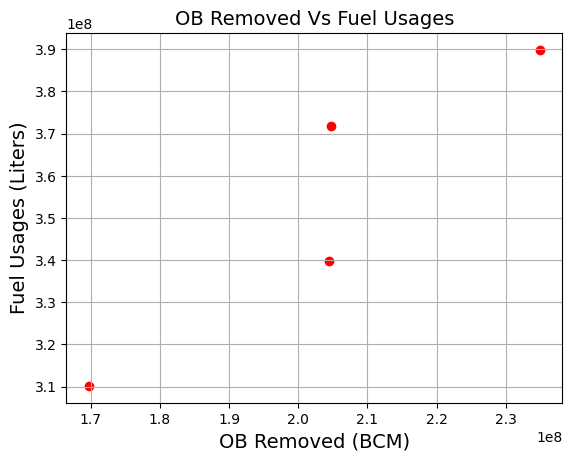

In [11]:
plt.scatter(dataset['OB (Bcm)'], dataset['Fuel'], color='red')
plt.title('OB Removed Vs Fuel Usages', fontsize=14)
plt.xlabel('OB Removed (BCM)', fontsize=14)
plt.ylabel('Fuel Usages (Liters)', fontsize=14)
plt.grid(True)
plt.show()

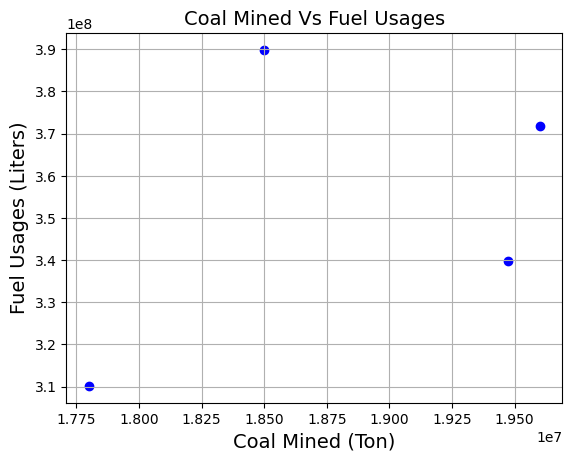

In [12]:
plt.scatter(dataset['Coal (Ton)'], dataset['Fuel'], color='blue')
plt.title('Coal Mined Vs Fuel Usages', fontsize=14)
plt.xlabel('Coal Mined (Ton)', fontsize=14)
plt.ylabel('Fuel Usages (Liters)', fontsize=14)
plt.grid(True)
plt.show()

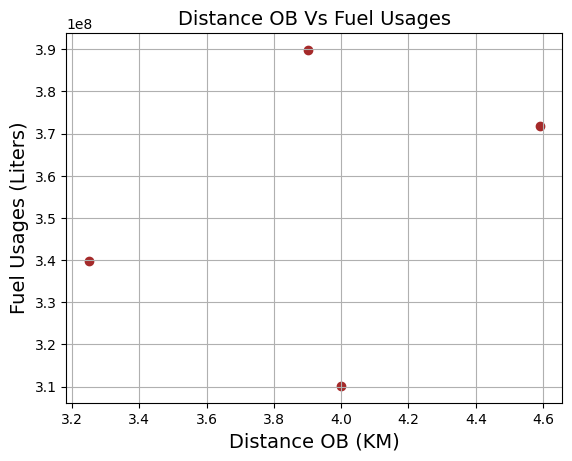

In [13]:
plt.scatter(dataset['Distance OB (KM)'], dataset['Fuel'], color='brown')
plt.title('Distance OB Vs Fuel Usages', fontsize=14)
plt.xlabel('Distance OB (KM)', fontsize=14)
plt.ylabel('Fuel Usages (Liters)', fontsize=14)
plt.grid(True)
plt.show()

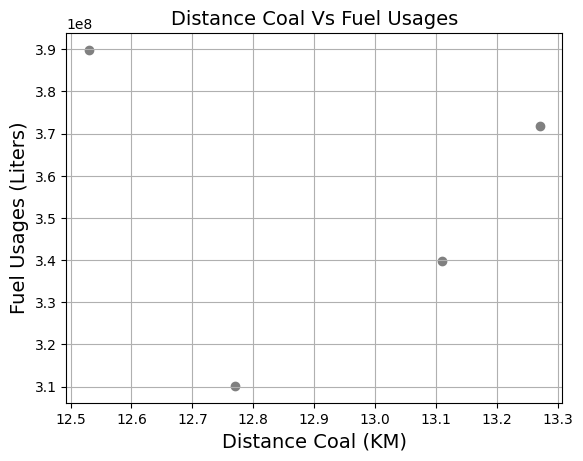

In [14]:
plt.scatter(dataset['Distance Coal (KM)'], dataset['Fuel'], color='gray')
plt.title('Distance Coal Vs Fuel Usages', fontsize=14)
plt.xlabel('Distance Coal (KM)', fontsize=14)
plt.ylabel('Fuel Usages (Liters)', fontsize=14)
plt.grid(True)
plt.show()

## From Linearity test above we found that OB Removed, and Coal (Ton) have linier relantionship with Fuel Usages

In [15]:
dataset = dataset.drop(['Year'], axis=1)

In [16]:
correlations = dataset.corr()
correlations['Fuel'].round(2)

OB (Bcm)              0.93
Coal (Ton)            0.42
Distance OB (KM)      0.30
Distance Coal (KM)   -0.11
Fuel                  1.00
Name: Fuel, dtype: float64

## From Corelation above 
We found that OB, Coal & Distance OB have corelation to Fuel, which have corelation point >= 0.2

In [17]:
from sklearn import linear_model
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, LeaveOneOut
import statsmodels.api as sm
import seaborn as sns

## Checking Outliers

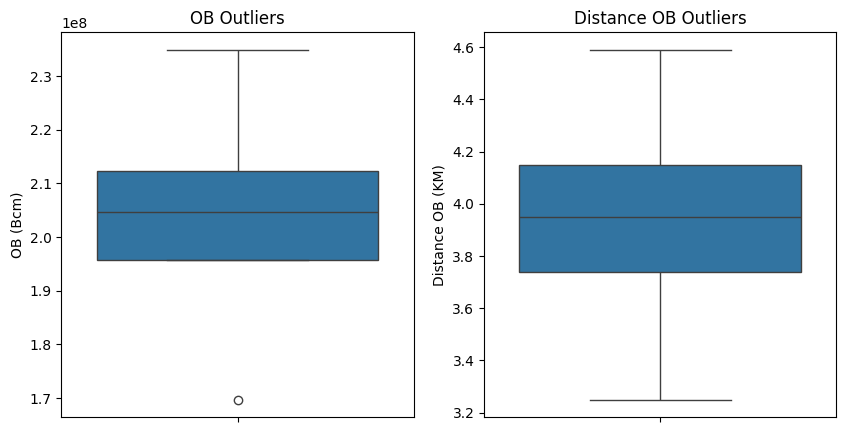

In [18]:
# Create box plots for each feature
plt.figure(figsize=(10, 5))

# OB Boxplot
plt.subplot(1, 2, 1)
sns.boxplot(y=dataset['OB (Bcm)'])
plt.title("OB Outliers")

# Coal Boxplot
plt.subplot(1, 2, 2)
sns.boxplot(y=dataset['Distance OB (KM)'])
plt.title("Distance OB Outliers")

plt.show()

In [19]:
# Compute IQR
Q1 = dataset[['OB (Bcm)', 'Distance OB (KM)']].quantile(0.25)
Q3 = dataset[['OB (Bcm)', 'Distance OB (KM)']].quantile(0.75)
IQR = Q3 - Q1

# Define lower and upper bounds
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Find outliers
outliers = ((dataset[['OB (Bcm)', 'Distance OB (KM)']] < lower_bound) | (dataset[['OB (Bcm)', 'Distance OB (KM)']] > upper_bound))

# Get row indices of outliers
outlier_indices = dataset[outliers.any(axis=1)].index
outlier_masks = dataset[outliers.any(axis=1)]
print("Outlier indices:", outlier_indices)

outlier_rows = dataset.loc[outlier_indices]
print(outlier_rows)

Outlier indices: Index([3], dtype='int64')
       OB (Bcm)  Coal (Ton)  Distance OB (KM)  Distance Coal (KM)  \
3  1.697078e+08  17800000.0               4.0               12.77   

           Fuel  
3  3.101740e+08  


## Clean Dataset without Outliers

In [20]:
dataset = dataset.drop(index=outlier_indices)  # Keep only rows without outliers
dataset

,OB (Bcm),Coal (Ton),Distance OB (KM),Distance Coal (KM),Fuel
0,2.044014e+08,19472489.78,3.25,13.11,339732231.0
1,2.349241e+08,18499998.43,3.90,12.53,389858150.0
2,2.047810e+08,19600000.00,4.59,13.27,371798713.0


In [21]:
correlations = dataset.corr()
correlations['Fuel'].round(2)

OB (Bcm)              0.78
Coal (Ton)           -0.70
Distance OB (KM)      0.62
Distance Coal (KM)   -0.63
Fuel                  1.00
Name: Fuel, dtype: float64

## Features & Target
Features (x) : Independent Variables = OB and Coal
Target (y) : Dependent Variable = Fuel

In [34]:
x = dataset[['OB (Bcm)','Distance OB (KM)']]
y = dataset['Fuel']
 
# Split dataset (70% Train, 30% Test) For Evaluation
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.1, random_state=42)

In [35]:
# ==============================
# Linear Regression (sklearn)
# ==============================
regr = linear_model.LinearRegression()
regr.fit(X_train, y_train)

LinearRegression()

In [36]:
# Predictions
y_train_pred = regr.predict(X_train)
y_test_pred = regr.predict(X_test)

In [41]:
# Metrics
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Cross-Validation (2-fold)
#kf = KFold(n_splits=1, shuffle=True, random_state=42)
#loo = LeaveOneOut()
#cv_scores = cross_val_score(regr, X_train, y_train, cv=kf, scoring='r2')

# Print Results
print("\n Model Performance Metrics:")
print(f"Train MSE: {train_mse:.3f} | Test MSE: {test_mse:.3f}")
print(f"Train MAE: {train_mae:.3f} | Test MAE: {test_mae:.3f}")
print(f"Train R² Score: {train_r2:.3f} | Test R² Score: {test_r2:.3f}")

#print("\n Cross-Validation Results:")
#print(f"R² Scores for each fold: {cv_scores.round(3)}")
#print(f"Mean R² Score: {cv_scores.mean():.3f} | Std Dev: {cv_scores.std():.3f}")


 Model Performance Metrics:
Train MSE: 0.000 | Test MSE: 1013726157364913.375
Train MAE: 0.000 | Test MAE: 31839066.528
Train R² Score: 1.000 | Test R² Score: nan


C:\Users\yudhia\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_regression.py:1266: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)


In [42]:
# ==============================
# Linear Regression (statsmodels)
# ==============================
regr = linear_model.LinearRegression()
regr.fit(x, y)
print("Final Model Intercept:", regr.intercept_.round(3))
print("Final Model Coefficients:", regr.coef_.round(3))

X_const = sm.add_constant(x)  # Add constant for intercept
model = sm.OLS(y, X_const).fit()
print("\n📌 Statsmodels Regression Summary:")
print(model.summary())

Final Model Intercept: 30089328.352
Final Model Coefficients: [1.14000000e+00 2.36074209e+07]

📌 Statsmodels Regression Summary:
                            OLS Regression Results                            
Dep. Variable:                   Fuel   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Thu, 10 Jul 2025   Prob (F-statistic):                nan
Time:                        14:59:26   Log-Likelihood:                 41.491
No. Observations:                   3   AIC:                            -76.98
Df Residuals:                       0   BIC:                            -79.69
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.9

C:\Users\yudhia\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\stats\stattools.py:125: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  skew = stats.skew(resids, axis=axis)
C:\Users\yudhia\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\stats\stattools.py:126: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  kurtosis = 3 + stats.kurtosis(resids, axis=axis)
C:\Users\yudhia\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\stats\stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 3 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
C:\Users\yudhia\AppData\Local\Programs\Python\Python313\Lib\site-packages\

In [39]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Define features (exclude 'Fuel' since it's the target variable)
features = ['OB (Bcm)','Distance OB (KM)','Distance Coal (KM)']
X = dataset[features]  

# Add a constant column for intercept
X = sm.add_constant(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

print(vif_data)

              Feature  VIF
0               const  0.0
1            OB (Bcm)  inf
2    Distance OB (KM)  inf
3  Distance Coal (KM)  inf


C:\Users\yudhia\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\regression\linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
C:\Users\yudhia\AppData\Local\Programs\Python\Python313\Lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


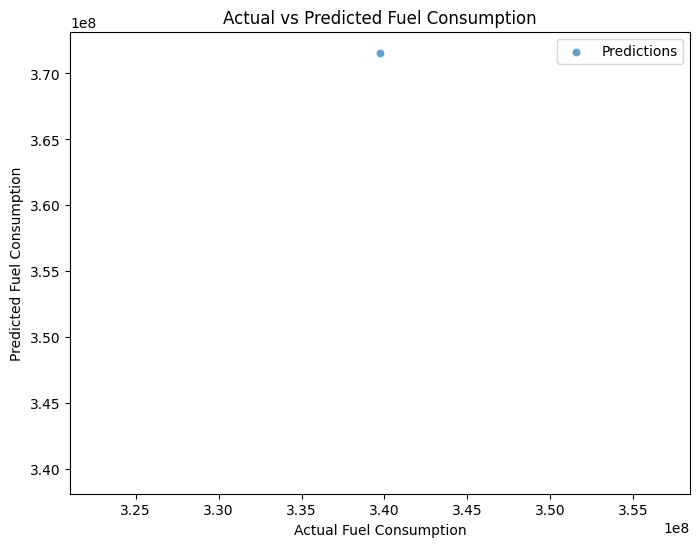

In [40]:
# ==============================
# Plot: Actual vs Predicted
# ==============================
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_test_pred, alpha=0.7, label="Predictions")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Fuel Consumption")
plt.ylabel("Predicted Fuel Consumption")
plt.title("Actual vs Predicted Fuel Consumption")
plt.legend()
plt.show()